In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from models import SBN
from utils import summary

In [4]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 'gray'] 

# Reading Dataset File

I'm going to call `summary`, but what does it do?

```
def summary(dataset, file_path):
    tree_dict_total = {}
    tree_dict_map_total = defaultdict(float)
    tree_names_total = []
    tree_wts_total = []
    n_samp_tree = 0
    for i in range(1, 11):
        tree_dict_rep, tree_name_rep, tree_wts_rep = mcmc_treeprob(file_path + dataset + '/rep_{}/'.format(i) + dataset + '.trprobs', 'nexus')
        tree_wts_rep = np.round(np.array(tree_wts_rep) * 750001)

        for i, name in enumerate(tree_name_rep):
            tree_id = tree_dict_rep[name].get_topology_id()
            if tree_id not in tree_dict_map_total:
                n_samp_tree += 1
                tree_names_total.append('tree_{}'.format(n_samp_tree))
                tree_dict_total[tree_names_total[-1]] = tree_dict_rep[name]

            tree_dict_map_total[tree_id] += tree_wts_rep[i]

    for key in tree_dict_map_total:
        tree_dict_map_total[key] /= 10 * 750001

    for name in tree_names_total:
        tree_wts_total.append(tree_dict_map_total[tree_dict_total[name].get_topology_id()])

    return tree_dict_total, tree_names_total, tree_wts_total
```

Iterating over $1 \to 10$ calling `mcmc_treeprob` on each dataset in `../data/raw_data_DS1-4/DS1`, `rep_` $1 \to 10$. What are these files?

In [5]:
ls ../data/raw_data_DS1-4/DS1/

rep_1/  rep_10/  rep_2/  rep_3/  rep_4/  rep_5/  rep_6/  rep_7/  rep_8/  rep_9/


In [6]:
!wc -l ../data/raw_data_DS1-4/DS1/rep_1/DS1.trprobs

1247 ../data/raw_data_DS1-4/DS1/rep_1/DS1.trprobs


The dataset file contains a description of what's in the file:

In [7]:
!head -n 7 ../data/raw_data_DS1-4/DS1/rep_1/DS1.trprobs

#NEXUS

[ID: 0146056142]
[This file contains the trees that were found during the MCMC
search, sorted by posterior probability. "p" indicates the
posterior probability of the tree whereas "P" indicates the
cumulative posterior probability.]


## `mcmc_treeprob`

What does `mcmc_treeprob` produce when supplied with one of these files?

In [8]:
from utils import mcmc_treeprob
tree_dict_rep, tree_name_rep, tree_wts_rep = mcmc_treeprob("../data/raw_data_DS1-4/DS1/rep_1/DS1.trprobs", "nexus")

`tree_dict_rep` is a dictionary containing numbered keys for each tree, with `ete3` objects called `TreeNode`s describing each tree:

In [9]:
k = tree_dict_rep.keys()
print(type(tree_dict_rep), len(k), k[:10])
for x in k[:3]:
    print(x, type(tree_dict_rep[x]), tree_dict_rep[x])

(<type 'dict'>, 1209, ['tree_919', 'tree_586', 'tree_496', 'tree_587', 'tree_1158', 'tree_1127', 'tree_559', 'tree_308', 'tree_309', 'tree_306'])
('tree_919', <class 'ete3.coretype.tree.TreeNode'>, Tree node '' (0x7f0d6e04281))
('tree_586', <class 'ete3.coretype.tree.TreeNode'>, Tree node '' (0x7f0d6ec4215))
('tree_496', <class 'ete3.coretype.tree.TreeNode'>, Tree node '' (0x7f0d6efcbe9))


`tree_name_rep` is just the keys from the dictionary `tree_dict_rep` sorted by their number:

In [ ]:
for a,b in zip(tree_name_rep, sorted(k, key=lambda x: int(x.split("_")[1]))):
    assert a == b

`tree_wts_rep` is a matched list with `tree_name_rep` containing weights for each tree. From `mcmc_tree_prob`:

```
def mcmc_treeprob(filename, data_type, truncate=None):
    mcmc_samp_tree_stats = Phylo.parse(filename, data_type)
    mcmc_samp_tree_dict = {}
    mcmc_samp_tree_name = []
    mcmc_samp_tree_wts = []
    num_hp_tree = 0
    for tree in mcmc_samp_tree_stats:
        handle = StringIO()
        Phylo.write(tree, handle, 'newick')
        mcmc_samp_tree_dict[tree.name] = Tree(handle.getvalue().strip())

        handle.close()
        mcmc_samp_tree_name.append(tree.name)
        mcmc_samp_tree_wts.append(tree.weight)
        num_hp_tree += 1

        if truncate and num_hp_tree >= truncate:
            break

    return mcmc_samp_tree_dict, mcmc_samp_tree_name, mcmc_samp_tree_wts
```

Where `Phylo` is `Bio.Phylo` from [Biopython's module for phylogenetics](http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc200). Which allows us to do cool stuff like render phylogenies in ascii:

In [10]:
from Bio import Phylo
tree_stats = Phylo.parse("../data/raw_data_DS1-4/DS1/rep_1/DS1.trprobs", "nexus")
tree = next(iter(tree_stats))

In [11]:
Phylo.draw_ascii(tree)

  __ Trachemys_scripta
 |
 |       ___ Sceloporus_undulatus
 |   ___|
 |  |   |___ Heterodon_platyrhinos
 |  |
 |  |        __ Turdus_migratorius
 |__|    ___|
 |  |   |   |__ Gallus_gallus
 |  |   |
 |  |   |       ___ Oryctolagus_cuniculus
 |  |___|      |
 |      |    __|        __ Rattus_norvegicus
 |      |   |  |    ___|
 |      |   |  |___|   |__ Mus_musculus
 |      |   |      |
 |      |___|      |___ Homo_sapiens
 |          |
 |          |   ___ Latimeria_chalumnae
 |          |  |
 |          |  |    ___ Xenopus_laevis
 |          |__|   |
 |             |   |           ___ Gastrophryne_carolinensis
 |             |   |       ___|
 |             |   |      |   |    __ Nesomantis_thomasseti
 |             |___|      |   |___|
_|                 |    __|       |__ Eleutherodactylus_cuneatus
 |                 |   |  |
 |                 |   |  |    ___ Hyla_cinerea
 |                 |   |  |___|
 |                 |   |      |___ Bufo_valliceps
 |                 |___|
 |   

So what `mcmc_treeprob` does is:

1. Open a dataset file, containing phylogenies sampled by MCMC
2. Parse all these trees using Biopython
3. For each tree:
    3. Write each of these trees to `newick` file format in a `StringIO` buffer
    4. Read this file format with `ete3` as a [`Tree`](http://etetoolkit.org/docs/latest/tutorial/tutorial_trees.html)
    5. Add this tree to a dictionary
    6. Add the a numbered key for this tree to a list
    7. Add a matched weight parameter produced by `ete3.Tree` to another list
4. Return a dictionary containing `ete3.Tree` objects, a list of keys for that dictionary and a list of weights matched to that list

Then, `summary` collates these lists and the dictionary over all of the 10 `rep_` files. It also scales the weights by 750001, rounds to make integers then later divides these integers by 750001 times 10 to make floats again. I suppose because there are 10 files. This summary function could cause problems if there are ever more or less than 10 `rep_` files.

In [12]:
tree_dict_total, tree_names_total, tree_wts_total = summary('DS1', '../data/raw_data_DS1-4/')

In [13]:
tree_wts_total[0]

0.2781518957974723

In [14]:
# make a new dictionary mapping ete3.Tree objects to weights
emp_tree_freq = {tree_dict_total[tree_name]:tree_wts_total[i] for i, tree_name in enumerate(tree_names_total)}

In [15]:
# get the list of taxa arbitrarily from the first tree
taxa = tree_dict_total[tree_names_total[0]].get_leaf_names()

In [16]:
# list of taxa matches the phylogeny drawn above
taxa

['Trachemys_scripta',
 'Sceloporus_undulatus',
 'Heterodon_platyrhinos',
 'Turdus_migratorius',
 'Gallus_gallus',
 'Oryctolagus_cuniculus',
 'Rattus_norvegicus',
 'Mus_musculus',
 'Homo_sapiens',
 'Latimeria_chalumnae',
 'Xenopus_laevis',
 'Gastrophryne_carolinensis',
 'Nesomantis_thomasseti',
 'Eleutherodactylus_cuneatus',
 'Hyla_cinerea',
 'Bufo_valliceps',
 'Typhlonectes_natans',
 'Siren_intermedia',
 'Ambystoma_mexicanum',
 'Discoglossus_pictus',
 'Scaphiopus_holbrooki',
 'Plethodon_yonhalossee',
 'Ichthyophis_bannanicus',
 'Hypogeophis_rostratus',
 'Grandisonia_alternans',
 'Amphiuma_tridactylum',
 'Alligator_mississippiensis']

# Opening `samp-tree` numpy arrays

In the previous section I opened a *raw* results directory, `raw_data_DS1-4`, containing the raw sampled trees from the MCMC experiments. The goal of the [paper][sbn] was to build a distribution over trees from a set of these samples. Now I'm opening numpy arrays in a results directory that's *not* raw, and contains many `.npy` pickled numpy arrays. What are these arrays? It says in the repository README to train a SBN we only need:

```
# parameters to train the model
#   @tree_dict is the unique tree dictionary
#   @tree_names is the name list of the trees
#   @tree_wts is the corresponding frequencies for the trees with names in tree_names
```

But, we've also supplied here the dictionary `emp_tree_freq` mapping trees to weights from the "golden runs".

## What are golden runs?

From [the paper][sbn]:

>  These extremely long “golden runs” form the ground truth to which we will compare various posterior estimates based on standard runs. For these standard runs, we run MrBayes on each data set with 10 replicates of 4 chains and 8 runs until the runs have ASDSF (the standard convergence criteria used in MrBayes) less than 0.01 or a maximum of 100 million iterations. This conservative setting has been shown to find all posterior modes on these data sets [Whidden and Matsen, 2015](https://academic.oup.com/sysbio/article/64/3/472/1632660). We collect the posterior samples every 100 iterations of these runs and discard the first 25% as burn-in. We apply SBN algorithms, SRF and CCD to the posterior samples in each of the 10 replicates for each data set. For sbn-em-α, we use $\alpha = 0.0001$ to give some weak regularization. We use KL divergence to the ground truth to measure the performance of all methods.

So, SBN, SFR and CCD are fitting distributions over trees to a subset of the full dataset of MCMC samples, then we compare the posterior distribution they've learnt against the distribution defined over the whole dataset *fit by counting*. **Where counting here, I think, is equivalent to SRF?**

## Why do these numpy arrays exist though?

But, that doesn't explain what these numpy arrays are, because I can get open each of these 10 replicate files individually, fit an SBN to each and calculate the KL divergence. It doesn't require an additional numpy array.

Oh, I think these are precomputed arrays increasing the number of samples, to produce the rightmost plot in Figure 5 of the paper. Should be easy to check this by trying to recreate that plot.

[sbn]: http://papers.nips.cc/paper/7418-generalizing-tree-probability-estimation-via-bayesian-networks

In [21]:
# reading figure 5 for sbn-sa
sbn_by_inspection = [(1e4, 0.2), (2e4, 0.14), (4e4, 0.1), (8e4, 0.09), (1.7e5, 0.08), (3e5, 0.071), (6e5, 0.07)]
srf_by_inspection = [(1e4, 0.31), (2e4, 0.21), (4e4, 0.13), (8e4, 0.08), (1.7e5, 0.044), (3e5, 0.025), (6e5, 0.014)]

In [18]:
# monkey patch np.load https://stackoverflow.com/a/56243777/6937913
# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [19]:
from IPython import display

In [20]:
K_v = [10000, 20000, 40000, 80000, 160000, 320000, 640000]
n_rep =10
kl_div_mat_freq = np.empty((n_rep, 7))

for rep in range(n_rep):
    display.clear_output() # added because original output was cluttered
    for k, n_trees in enumerate(K_v):
        print 'rep {}, sample size: {}'.format(rep+1, n_trees)
        
        tree_id = np.load('../data/DS1/rep_{}/{}-samp-tree-dict.npy'.format(rep+1, n_trees)).item()
        tree_count_dict = np.load('../data/DS1/rep_{}/{}-samp-tree-count-dict.npy'.format(rep+1, n_trees)).item()
        
        model = SBN(taxa, emp_tree_freq)
        model.bn_train_count(tree_count_dict, tree_id)
        
        kl_div = model.kl_div(method='freq')
        kl_div_mat_freq[rep, k] = kl_div['freq']

        print 'rep {}, kl_div {}'.format(rep+1, kl_div_mat_freq[rep, k])

rep 10, sample size: 10000
rep 10, kl_div 0.595205170487
rep 10, sample size: 20000
rep 10, kl_div 0.384487654816
rep 10, sample size: 40000
rep 10, kl_div 0.20654767478
rep 10, sample size: 80000
rep 10, kl_div 0.103092987773
rep 10, sample size: 160000
rep 10, kl_div 0.0422549707374
rep 10, sample size: 320000
rep 10, kl_div 0.0242059842406
rep 10, sample size: 640000
rep 10, kl_div 0.0136130249259


Plotting against values read from Figure 5 of the paper:

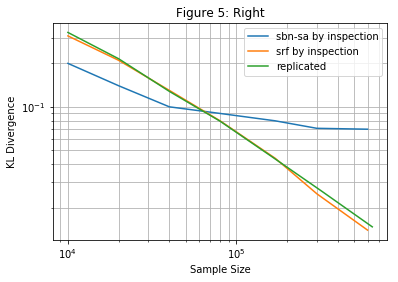

In [23]:
plt.title("Figure 5: Right")
plt.plot(*zip(*sbn_by_inspection), label="sbn-sa by inspection")
plt.plot(*zip(*srf_by_inspection), label="srf by inspection")
plt.plot(K_v, kl_div_mat_freq.mean(axis=0), label="replicated")
plt.xlabel("Sample Size")
plt.xscale("log")
plt.ylabel("KL Divergence")
plt.yscale("log")
plt.legend()
plt.grid(which="both")

I suppose when we fit a SBN by counting then we're fitting by SRF? The replicated line looks exactly like the SRF line from Figure 5 in the paper and I'm sure it's neither of the EM algorithms because the code to fit those is in the next part.

In [25]:
if not os.path.exists('../results/DS1/method'):
    os.makedirs('../results/DS1/method')
if not os.path.exists('../results/DS1/n-tree'): # fixed '../results/DS1/n_tree' ->  '../results/DS1/n-tree'
    os.makedirs('../results/DS1/n-tree')

In [27]:
from time import time

The following cell took a long time to run, so I added some code that makes it easier to check progress and figure out how  long it's got left to run. It also flooded the cell output with status updates, so I used `clear_output` to reduce that and make the output more readable.

In [43]:
K_v = [10000, 20000, 40000, 80000, 160000, 320000, 640000]
methods = ['ccd', 'sbn-sa', 'sbn-em', 'sbn-em-alpha']
n_rep = 10
reg_lam = 100.0
kl_div_mat = np.empty((n_rep, 7, 4))

status = ""
def clear_and_print(status):
    display.clear_output()
    print(status)
start_time = time()
for rep in range(n_rep):
    elapsed = time() - start_time
    if rep > 0:
        per_rep = elapsed/rep
        seconds = per_rep*(n_rep-rep)
        status  = "remaining: {:d} minutes {:.2f} seconds".format( int(seconds//60), seconds%60) + "\n"

    output_methods = '../results/DS1/method/rep' + '{:02d}'.format(rep+1)
    output_n_unique_tree = '../results/DS1/n-tree/rep' +'{:02d}'.format(rep+1)

    kl_div_methods = open(output_methods, 'w')
    n_unique_tree = open(output_n_unique_tree, 'w')
    
    kl_div_methods.write('K'.ljust(8) + '\t'.join([str(method).ljust(13) for method in methods]) +'\n')
    n_unique_tree.write('\t'.join([str(n_tree).ljust(6) for n_tree in K_v]) +'\n')
    
    kl_div_methods.flush()
    n_unique_tree.flush()    
    
    for k, n_trees in enumerate(K_v):
        kl_div_methods.write('{:06d}'.format(n_trees))
        status += 'rep {}, dataset {}, sample size {}, loading data'.format(rep, 'DS1', n_trees)
        clear_and_print(status)
        status += ' : DONE\n'
        tree_id = np.load('../data/DS1/rep_{}/{}-samp-tree-dict.npy'.format(rep+1, n_trees)).item()
        tree_count_dict = np.load('../data/DS1/rep_{}/{}-samp-tree-count-dict.npy'.format(rep+1, n_trees)).item()
        
        model = SBN(taxa, emp_tree_freq)
        model.bn_train_count(tree_count_dict, tree_id)

        kl_div = model.kl_div()
        kl_div_mat[rep, k, 0], kl_div_mat[rep, k, 1] = kl_div['ccd'], kl_div['bn']

        status += 'SBN-EM training: rep {}, dataset {}, sample size {}'.format(rep, 'DS1', n_trees)
        clear_and_print(status)
        status += ' : DONE\n'
        logp = model.bn_em_count(tree_count_dict, tree_id, maxiter=1000, abstol=1e-05, monitor=True, MAP=False)
        kl_div_mat[rep, k, 2] = model.kl_div(method='bn')['bn']   
        
        model = SBN(taxa, emp_tree_freq, alpha=reg_lam/n_trees)
        status += 'SBN-EM-ALPHA training: rep {}, dataset {}, sample size {}'.format(rep, 'DS1', n_trees)
        clear_and_print(status)
        status += ' : DONE\n'
        logp = model.bn_em_count(tree_count_dict, tree_id, maxiter=1000, abstol=1e-05, monitor=True, MAP=True)
        kl_div_mat[rep, k, 3] = model.kl_div(method='bn', MAP=True)['bn']
        
        kl_div_methods.write(''.join(['\t{:.11f}'.format(kl_div_mat[rep,k,l]) for l in range(4)]) + '\n')
        n_unique_tree.write(str(len(tree_count_dict)).ljust(6)+'\t')

        kl_div_methods.flush()
        n_unique_tree.flush()

    n_unique_tree.write('\n')
    
    kl_div_methods.close()
    n_unique_tree.close()            

remaining: 44 minutes 16.44 seconds
rep 9, dataset DS1, sample size 10000, loading data : DONE
SBN-EM training: rep 9, dataset DS1, sample size 10000 : DONE
SBN-EM-ALPHA training: rep 9, dataset DS1, sample size 10000 : DONE
rep 9, dataset DS1, sample size 20000, loading data : DONE
SBN-EM training: rep 9, dataset DS1, sample size 20000 : DONE
SBN-EM-ALPHA training: rep 9, dataset DS1, sample size 20000 : DONE
rep 9, dataset DS1, sample size 40000, loading data : DONE
SBN-EM training: rep 9, dataset DS1, sample size 40000 : DONE
SBN-EM-ALPHA training: rep 9, dataset DS1, sample size 40000 : DONE
rep 9, dataset DS1, sample size 80000, loading data : DONE
SBN-EM training: rep 9, dataset DS1, sample size 80000 : DONE
SBN-EM-ALPHA training: rep 9, dataset DS1, sample size 80000 : DONE
rep 9, dataset DS1, sample size 160000, loading data : DONE
SBN-EM training: rep 9, dataset DS1, sample size 160000 : DONE
SBN-EM-ALPHA training: rep 9, dataset DS1, sample size 160000 : DONE
rep 9, dataset D

In [44]:
elapsed = time()-start_time
print("{:d} minutes elapsed".format(int(elapsed)//60))

438 minutes elapsed


In [46]:
kl_div_mat_merg = np.concatenate((kl_div_mat, kl_div_mat_freq.reshape(n_rep, 7, -1)), axis=2)

In [47]:
model = SBN(taxa, emp_tree_freq)

In [48]:
logp = model.bn_em_prob(tree_dict_total, tree_names_total, tree_wts_total, maxiter=100, abstol=1e-05, monitor=True, MAP=False)

Iter 1: current per tree log-likelihood -2.954282
Iter 2: current per tree log-likelihood -2.950041
Iter 3: current per tree log-likelihood -2.949119
Iter 4: current per tree log-likelihood -2.948953
Iter 5: current per tree log-likelihood -2.948856
Iter 6: current per tree log-likelihood -2.948778
Iter 7: current per tree log-likelihood -2.948709
Iter 8: current per tree log-likelihood -2.948643
Iter 9: current per tree log-likelihood -2.948577
Iter 10: current per tree log-likelihood -2.948517
Iter 11: current per tree log-likelihood -2.948470
Iter 12: current per tree log-likelihood -2.948433
Iter 13: current per tree log-likelihood -2.948401
Iter 14: current per tree log-likelihood -2.948369
Iter 15: current per tree log-likelihood -2.948329
Iter 16: current per tree log-likelihood -2.948275
Iter 17: current per tree log-likelihood -2.948194
Iter 18: current per tree log-likelihood -2.948071
Iter 19: current per tree log-likelihood -2.947880
Iter 20: current per tree log-likelihood

In [49]:
bn_em_est_prob = [model.bn_estimate(tree_dict_total[tree_name]) for tree_name in tree_names_total]

In [50]:
sum(bn_em_est_prob), max(bn_em_est_prob)

(0.9994882515181007, 0.27499234412280765)

In [51]:
kl_div_mean = np.mean(kl_div_mat_merg, axis=0)
kl_div_std = np.std(kl_div_mat_merg, axis=0)

In [52]:
K_v = [10000, 20000, 40000, 80000, 160000, 320000, 640000]
labels={0:'ccd',1:'sbn-sa',2:'sbn-em',3:'sbn-em-'+r'$\alpha$',4:'srf'}
fmts={0:'-o',1:'-s',2:'-d',3:'-^',4:'--P'}
marksz={0:5,1:5,2:6,3:6,4:6}

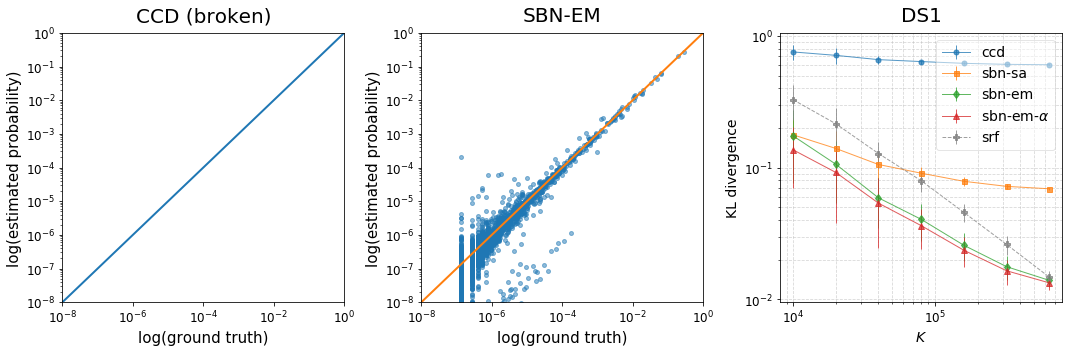

In [60]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
# badly saved notebook state, ccd_est_prob does not exist
#ax1.plot(tree_wts_total, ccd_est_prob, 'o', markersize=4, alpha=0.5)
ax1.set_xlim([1e-8,1])
ax1.set_ylim(ax1.get_xlim())
ax1.loglog([1e-8,1],[1e-8,1],linewidth=2)
ax1.set_title('CCD (broken)', y=1.02, fontsize=20)
ax1.set_xlabel('log(ground truth)',fontsize=15)
ax1.set_ylabel('log(estimated probability)',fontsize=15)
ax1.tick_params(labelsize=12)

ax2.plot(tree_wts_total, bn_em_est_prob, 'o', markersize=4, alpha=0.5)
ax2.set_xlim([1e-8,1])
ax2.set_ylim(ax2.get_xlim())
ax2.loglog([1e-8,1],[1e-8,1],linewidth=2)
ax2.set_title('SBN-EM', y=1.02, fontsize=20)
ax2.set_xlabel('log(ground truth)',fontsize=15)
ax2.set_ylabel('log(estimated probability)',fontsize=15)
ax2.tick_params(labelsize=12)


ax3.set_xscale('log')
ax3.set_yscale('log')
for i in [0,1,2,3,4]:
    ax3.errorbar(K_v, kl_div_mean[:,i], yerr=kl_div_std[:,i], c=colors[i], label=labels[i], fmt=fmts[i],markersize=marksz[i], alpha=0.75, linewidth=1)
    
leg = ax3.legend(loc='best',fontsize=14)
leg.get_frame().set_alpha(0.5)
ax3.grid(which='both', linestyle='--', alpha=0.5)
ax3.tick_params(labelsize=12)
ax3.set_xlabel(r'$K$', fontsize=14)
ax3.set_ylabel('KL divergence', fontsize=14)
ax3.set_title('DS1', y=1.02, fontsize=20)

plt.tight_layout()

plt.show()

# Questions

* Can we confirm that counting frequencies of phylogenies is equivalent to SRF? **Yes, because the line labeled srf in the rightmost figure corresponds to the `kl_div_mat_freq` matrix produced when fitting the SBN by counting in cell 20 above.**


In [59]:
labels[4]

'srf'